In [1]:
seed = 42
import random
random.seed( seed )
import numpy as np
np.random.seed(seed)

from ultils_for_ML_binary_classify import *
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


# DCA Plot

In [2]:
import os
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

dir_result = './SCI-Paper-results-los_hospital'# where to save results
final_allsave_filename = os.path.join(dir_result,'all_python_vars_V1.npy') 
    
result_vars = np.load(final_allsave_filename, allow_pickle=True)
processed_data = result_vars.item()['processed_data']
mean_aucs_matrix = result_vars.item()['mean_aucs_matrix']
aucs_testset_matrix = result_vars.item()['aucs_testset_matrix']
all_name_selected_features = result_vars.item()['all_name_selected_features']
best_clfs_matrix_noDNN = result_vars.item()['best_clfs_matrix_noDNN']
Stacking_clf = result_vars.item()['Stacking_clf']
# stackingclassifier_selected_features = result_vars.item()['stackingclassifier_selected_features']
# feat_imp = result_vars.item()['feat_imp']
ret_ensembest_clf = result_vars.item()['ret_ensembest_clf']

best_clfs_matrix_noDNN.rename(columns={"REF": "RFE"},inplace=True)
all_name_selected_features["RFE"] = all_name_selected_features.pop("REF")

In [3]:
kbest = 3
best_alg_comb = [("Bagging","EmbeddingLR"),("LDA","EmbeddingLR"),("AdaBoost","EmbeddingLR")]
best_clf = np.zeros([kbest]).tolist()
pipeline = np.zeros([kbest]).tolist()
for k in range(kbest):
    clf_name = best_alg_comb[k][0]
    feature_selector_name = best_alg_comb[k][1]
    best_clf[k] = best_clfs_matrix_noDNN.loc[ clf_name ][ feature_selector_name ]
    
    selected_features = all_name_selected_features[feature_selector_name]#特征名称列表
    selector = DataFrameSelector(selected_features)

    pipeline[k] = (clf_name+'_'+feature_selector_name,
                   Pipeline( [('selector',selector),('clf',best_clf[k])] )
                  )
    
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
Stacking_clf = StackingClassifier(estimators=pipeline)
X_train = processed_data['X_train']#.values#dataframe
X_test = processed_data['X_test']#.values#dataframe
Y_train = processed_data['Y_train'].values
Y_test = processed_data['Y_test'].values
X_external,Y_external = None,None
class_names = processed_data['class_names']
Stacking_clf.fit(X_train,Y_train)

# calibrated_Stacking_clf = CalibratedClassifierCV(Stacking_clf, cv='prefit', method='sigmoid')
# calibrated_Stacking_clf = calibrated_Stacking_clf.fit(X_train, Y_train)

print("Stacking_clf get!")

Stacking_clf get!


In [4]:
kbest = 3
best_alg_comb = [("Logistic","RFE"),("Bagging","EmbeddingLR"),("AdaBoost","RFE")]
best_clf = np.zeros([kbest]).tolist()
calibrated_best_clf = np.zeros([kbest]).tolist()
pipeline = np.zeros([kbest]).tolist()

for k in range(kbest):
    clf_name = best_alg_comb[k][0]
    feature_selector_name = best_alg_comb[k][1]
    best_clf[k] = best_clfs_matrix_noDNN.loc[ clf_name ][ feature_selector_name ]
    
    selected_features = all_name_selected_features[feature_selector_name]#特征名称列表
    selector = DataFrameSelector(selected_features)
    
    calibrated_best_clf[k] = CalibratedClassifierCV(best_clf[k], cv='prefit', method='sigmoid')
    calibrated_best_clf[k] = calibrated_best_clf[k].fit(selector.transform(X_train), Y_train)
    
#     pipeline[k] = (
#         clf_name+'_'+feature_selector_name,
#         Pipeline( [('selector',selector),('clf',best_clf[k])] )
#     )
    
    pipeline[k] = (
        clf_name+'_'+feature_selector_name,
        Pipeline( [('selector',selector),('clf',calibrated_best_clf[k])] )
    )
    


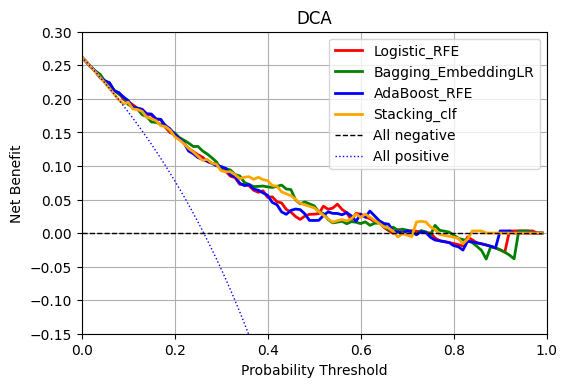

In [5]:
def get_DCA_coords(y_pred,y_true,fn="DCA.png"):
    """
    get coordinates of points of DCA curve
    """
    pt_arr = []
    net_bnf_arr = []
    y_pred = y_pred.ravel()
    for i in range(0,100,1):
        pt = i /100
        #compute TP FP
        y_pred_clip = (y_pred>pt).astype(int)
        TP = np.sum( y_true*np.round(y_pred_clip) )
        FP = np.sum((1 - y_true) * np.round(y_pred_clip))
        net_bnf = ( TP-FP* pt/(1-pt) )/len(y_true)
#         print('pt {}, TP {}, FP {}, net_bf {}'.format(pt,TP,FP,net_bnf))
        pt_arr.append(pt)
        net_bnf_arr.append(net_bnf)
    
    return pt_arr, net_bnf_arr

def plot_multiclfs_DCA(clfs,X,y_true,fn="DCA.png"):
    """
    plot DCA for multi-classifiers
    """
    pi = np.sum(y_true)/len(y_true)# Prevalence
    fig = plt.figure(dpi=100)
    colors = ["red","green","blue","orange"]
    for (clf_name, clf), color in zip(clfs,colors):
        y_proba = clf.predict_proba(X)[:,1]
        pt_arr, net_bnf_arr = get_DCA_coords(y_proba,y_true)
        plt.plot(pt_arr, net_bnf_arr, color=color, lw=2, linestyle='-',label=clf_name)
        
    plt.plot(pt_arr, np.zeros(len(pt_arr)), color='k', lw=1, linestyle='--',label='All negative')
    pt_np = np.array(pt_arr)
    all_pos = pi-(1-pi)*pt_np/(1-pt_np)
    plt.plot(pt_arr, all_pos , color='b', lw=1, linestyle='dotted',label='All positive')
    plt.xlim([0.0, 1.0])
    plt.ylim([-0.15, 0.3])
    plt.xlabel('Probability Threshold')
    plt.ylabel('Net Benefit')
    plt.title('DCA')
    plt.legend()
    plt.grid("on")
    plt.savefig(fn)
    plt.show()
    return None

clfs = pipeline+[("Stacking_clf",Stacking_clf)]
fn = os.path.join(dir_result,"DCA of Top3 and StackingClf.png")
plot_multiclfs_DCA(clfs,X_test,Y_test,fn=fn)

# report: recall, precision, f1-score


In [6]:
from sklearn.metrics import f1_score, recall_score

best_thresholds = dict([])
for clf_name, clf in pipeline+[("Stacking_clf",Stacking_clf)]:
    y_true = Y_train
    y_proba = clf.predict_proba(X_train)[:,1]
    
    weight_neg = 1
    weight_pos = 2
    sample_weight = (y_true==0)*weight_neg + (y_true==1)*weight_pos
    
    score = []
    ts = np.linspace(0,1,101)   
    for t in ts:
        y_pred = y_proba>t
        #score.append( recall_score(y_true, y_pred, average='macro', sample_weight=sample_weight) )#f1_score #recall_score average='binary'
        recalls = recall_score(y_true, y_pred, average=None)
        score.append( (recalls[0]*weight_neg+recalls[1]*weight_pos)/(weight_neg+weight_pos) )
    score = np.array(score)
    idx = np.where(score==score.max())[0][0]
    best_threshold = min( max(0.2,ts[idx] ),0.8 )
    idx = np.where(ts==best_threshold)
    best_thresholds[clf_name] = ( ts[idx], score[idx] )
print(best_thresholds)

from sklearn.metrics import classification_report
for clf_name, clf in pipeline+[("Stacking_clf",Stacking_clf)]:
    y_true = Y_test
    y_pred = clf.predict_proba(X_test)[:,1]>best_thresholds[clf_name][0]
    target_names = ['<= 7d', '> 7d']
    print()
    print('\033[1m' + clf_name+":" + '\033[0m')
    print(best_thresholds[clf_name][0])
    print(classification_report(y_true, y_pred, target_names=target_names))    
    print("\n\n")

{'Logistic_RFE': (array([0.2]), array([0.76373319])), 'Bagging_EmbeddingLR': (array([0.2]), array([0.76591089])), 'AdaBoost_RFE': (array([0.2]), array([0.75941145])), 'Stacking_clf': (array([0.2]), array([0.75686765]))}

Logistic_RFE:
[0.2]
              precision    recall  f1-score   support

       <= 7d       0.90      0.68      0.77       236
        > 7d       0.46      0.79      0.58        84

    accuracy                           0.71       320
   macro avg       0.68      0.73      0.68       320
weighted avg       0.78      0.71      0.72       320





Bagging_EmbeddingLR:
[0.2]
              precision    recall  f1-score   support

       <= 7d       0.90      0.67      0.77       236
        > 7d       0.47      0.80      0.59        84

    accuracy                           0.71       320
   macro avg       0.68      0.74      0.68       320
weighted avg       0.79      0.71      0.72       320





AdaBoost_RFE:
[0.2]
              precision    recall  f1-score   supp

Logistic_RFE :


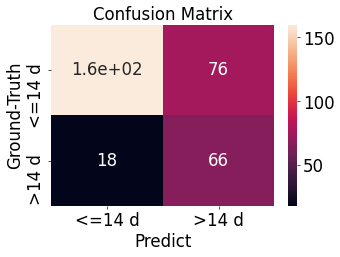




Bagging_EmbeddingLR :


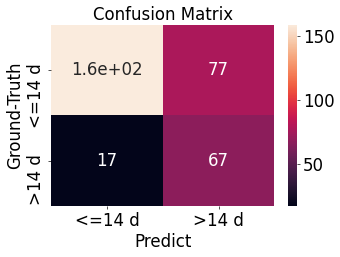




AdaBoost_RFE :


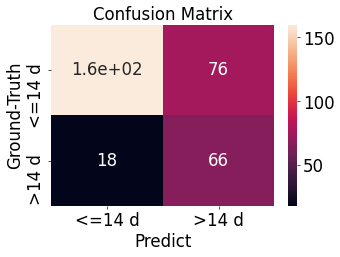




Stacking_clf :


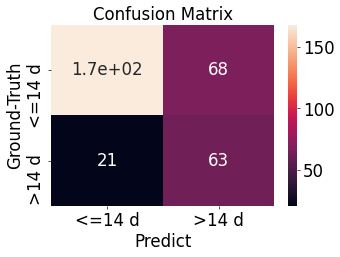

In [7]:
from ultils_for_ML_binary_classify import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

for clf_name, clf in pipeline+[("Stacking_clf",Stacking_clf)]:
    y_true = Y_test
    y_pred = clf.predict_proba(X_test)[:,1]>best_thresholds[clf_name][0]

    print(clf_name,":")    
    cm = confusion_matrix( y_true, y_pred )
    class_names = ['<=14 d','>14 d']
    num_classes = 2
    plot_confusion_matrix(
        cm,class_names,
        title='Confusion Matrix',
        fn=None,
        fmt='.2g',
        center=None)
    print("\n\n")

# AUC Matrix Plot

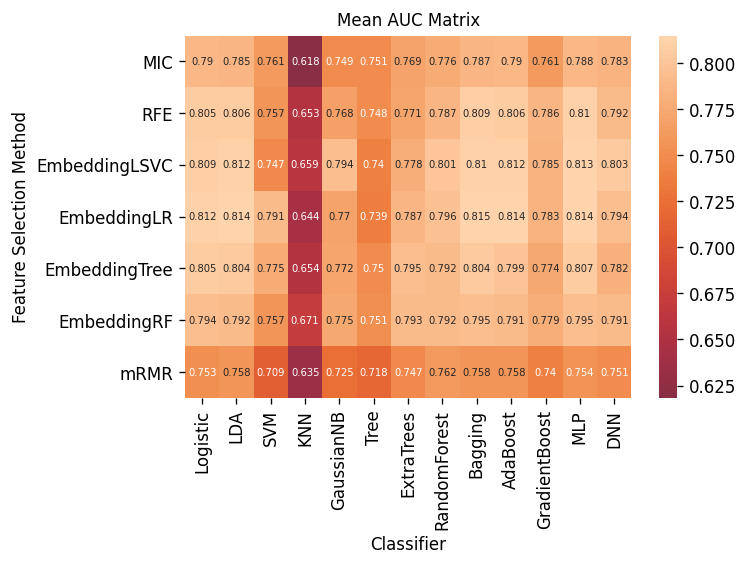

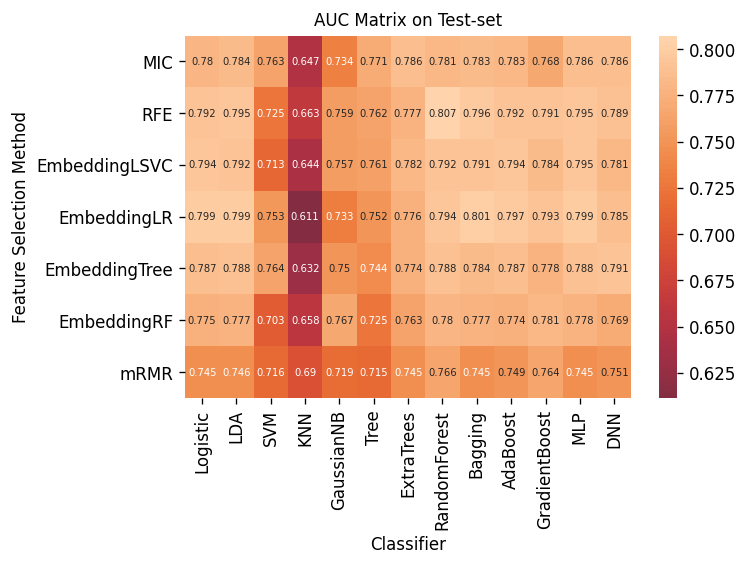

(<Figure size 720x480 with 2 Axes>,
 <AxesSubplot:title={'center':'AUC Matrix on Test-set'}, xlabel='Classifier', ylabel='Feature Selection Method'>)

In [8]:
# plot auc matrix
def plot_mean_aucs_matirx(mean_aucs_matrix, fmt='.3g',center=0.5,
                          title='mean AUC Matrix',
                          fn='mean AUC Matrix.png'
                         ):
    """
    plot cv mean auc matrix：axis x is classification algo，axis y is feature selection methods，values are mean_auc
    """

    cm = mean_aucs_matrix.values
    algorithms = mean_aucs_matrix.columns.tolist()
    feature_selection_methods = mean_aucs_matrix.index.tolist()
    
    f,ax = plt.subplots(dpi=120)
    ax = sns.heatmap(cm,annot=True,fmt=fmt,center=center,annot_kws={'size':6,'ha':'center','va':'center'})
    ax.set_title(title,fontsize=10)
    ax.set_xlabel('Classifier',fontsize=10)
    ax.set_ylabel('Feature Selection Method',fontsize=10)
    ax.set_xticklabels(algorithms,fontsize=10, rotation='vertical')
#     plt.xticks([y+1 for y in range(len(x))], x_names, rotation='vertical')
    ax.set_yticklabels(feature_selection_methods,fontsize=10, rotation='horizontal')
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=10)# set font-size of colorbar ticks
    
    plt.savefig(fn, bbox_inches='tight')
    plt.show()
    return f,ax

mean_aucs_matrix.rename(columns={"REF": "RFE"},inplace=True)
aucs_testset_matrix.rename(columns={"REF": "RFE"},inplace=True)
#　CV AUC
plot_mean_aucs_matirx(mean_aucs_matrix.T, fmt='.3g',
                      title='Mean AUC Matrix',
                      fn=os.path.join(dir_result,'mean AUC Matrix on Train Set RepeatedKFold Cross Validation.png'))
#　internal-test-set AUC
plot_mean_aucs_matirx(aucs_testset_matrix.T, fmt='.3g',
                      title='AUC Matrix on Test-set',
                      fn=os.path.join(dir_result,'AUC Matrix on Test Set.png'))